<a href="https://colab.research.google.com/github/mafie1/IA-pour-la-physique/blob/main/IA_pour_la_physique_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Intelligence artificielle pour la physique

#### General imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from tqdm import tqdm
from google.colab import drive

#### Sklearn imports

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Partie 1: Exploration des données

In [ ]:
#@title Read in data
def read_t(t,root="./Ising/"):
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    return np.unpackbits(data).astype(int).reshape(-1, 1600)

In [ ]:
drive.mount('/content/gdrive')
!ls '/content/gdrive/My Drive/IA pour la physique'

Mounted at /content/gdrive
'Copy of IA_pour_la_physique_main.ipynb'   Ising   temperature_grid_images.png


In [ ]:
!pwd

/content


In [ ]:
%cd /content/gdrive/My Drive/IA pour la physique
!ls

/content/gdrive/My Drive/IA pour la physique
'Copy of IA_pour_la_physique_main.ipynb'   Ising   temperature_grid_images.png


In [ ]:
t_0 = 2.25
T_s = np.linspace(0.25, 4, 16)
print(*T_s)

data_0 = read_t(t_0, root="./Ising/")

0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 2.25 2.5 2.75 3.0 3.25 3.5 3.75 4.0


**nombre et dimension**

In [ ]:
data_0.shape

(10000, 1600)

In [ ]:
sample_image_0_25 = read_t(0.25, root="./Ising/")[0, :].reshape(40, 40)
sample_image_0_50 = read_t(0.50, root="./Ising/")[0, :].reshape(40, 40)
sample_image_0_75 = read_t(0.75, root="./Ising/")[0, :].reshape(40, 40)
sample_image_2_25 = data_0[0, :].reshape(40, 40)
sample_image_4_00 = read_t(4.0, root="./Ising/")[0, :].reshape(40, 40)

 For each temperature, we have $10^4$ states on a grid with 40x40 = 1600 positions.


**nom, signification et type (numérique/catégoriel) des variables**

In [ ]:
"""min_val, max_val = 0, 1

cm = sns.light_palette("blue", as_cmap=True)
x = pd.DataFrame(sample_image)
x = x.style.background_gradient(cmap=cm)
display(x)"""

'min_val, max_val = 0, 1\n\ncm = sns.light_palette("blue", as_cmap=True)\nx = pd.DataFrame(sample_image)\nx = x.style.background_gradient(cmap=cm)\ndisplay(x)'

In [ ]:
X_input = np.empty((16, 10000, 1600))
y_input = np.empty((16, 10000))

for i, t in enumerate(tqdm(T_s)):
  X_input[i] = read_t(t, root="./Ising/")
  y_input[i] = t

100%|██████████| 16/16 [00:04<00:00,  3.58it/s]


In [ ]:
inv_temp = [1/t for t in T_s] # define the inverse temperature
print(*inv_temp)

4.0 2.0 1.3333333333333333 1.0 0.8 0.6666666666666666 0.5714285714285714 0.5 0.4444444444444444 0.4 0.36363636363636365 0.3333333333333333 0.3076923076923077 0.2857142857142857 0.26666666666666666 0.25


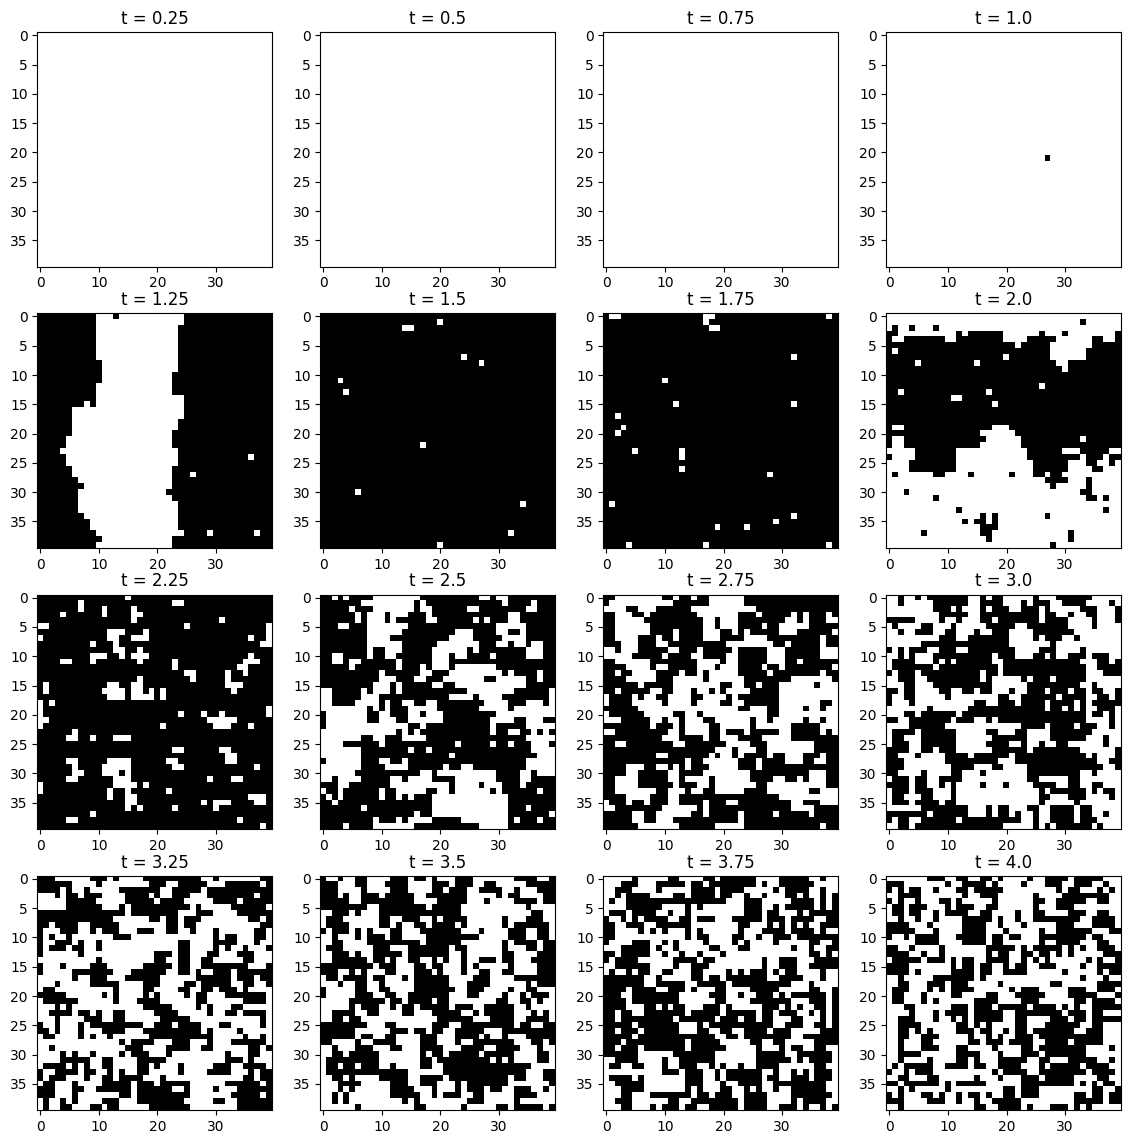

In [ ]:
#f, axarr = plt.subplots(4,4)
plt.figure(figsize=(14,14))

for i, t in enumerate(T_s):
  plt.subplot(4,4,i+1)

  plt.imshow(X_input[i][0].reshape(40, 40), cmap = 'Greys')
  plt.title('t = %s' %((i+1)*0.25))

plt.savefig('temperature_grid_images')

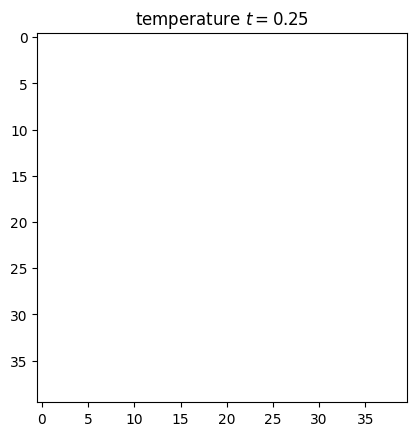

In [ ]:
plt.title(r'temperature $t = 0.25$')
plt.imshow(sample_image_0_25, cmap = 'Greys')

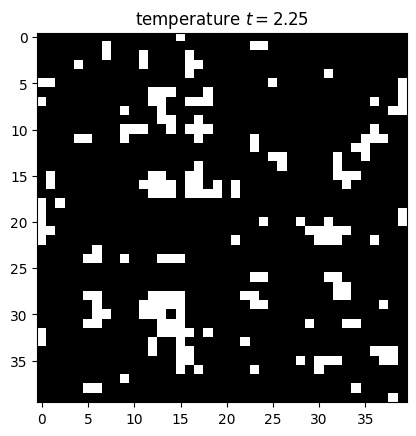

In [ ]:
plt.title(r'temperature $t = 2.25$')
plt.imshow(sample_image_2_25, cmap = 'Greys')

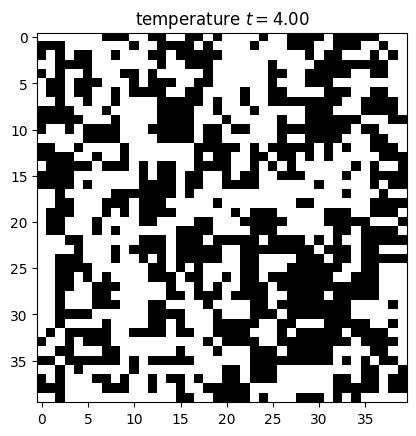

In [ ]:
plt.title(r'temperature $t = 4.00$')
plt.imshow(sample_image_4_00, cmap = 'Greys')

**y a-t-il des données manquantes ?**

In [ ]:
# no

**préciser la nature du problème (classification/régression)** <br>
Les autheurs du papier '...' traitent ce problème comme un problème de classification sur les 16 categories = les temperatures.

**définir les objectifs et la métrique d’évaluation**

## Partie 2: Préparation des données




**séparation entraînement/test et mettre les données de test de côté**
We will make an 80-10-10 split

In [ ]:
#reshape to get 16*10^4 training samples each with 1600 features
X_input = X_input.reshape(-1, 1600)
y_input = y_input.reshape(-1)

In [ ]:
#get initial split between data used for verification (test + val) & training
X_train, X_ver, y_train, y_ver  = train_test_split(X_input, y_input, train_size = 0.8, random_state = 0)

print(X_train.shape, X_ver.shape)
print(y_train.shape, y_ver.shape)

(128000, 1600) (32000, 1600)
(128000,) (32000,)


In [ ]:
# get validation data to do intermediary performance evaluation + hyperparameter optimization
X_test, X_val, y_test, y_val = train_test_split(X_ver, y_ver, train_size = 0.5, random_state = 0)

print(y_train.shape, y_val.shape)

(128000,) (16000,)


**examiner les statistiques des différents descripteurs (min, max,
moyenne, écart-type, distribution, corrélations)**

In [ ]:
# Example DataFrame creation (replace this with your actual dataset)
np.random.seed(42)
num_samples = 160000
num_features = 1600
temperatures = np.linspace(0.25, 4.0, num_samples // 1600)
spin_configurations = np.random.choice([-1, 1], size=(num_samples, num_features))

ising_data = pd.DataFrame({
    'Temperature': temperatures,
    'SpinConfig': list(spin_configurations)
})

# Calculate correlation matrix
correlation_matrix = ising_data['SpinConfig'].apply(lambda x: pd.Series(x)).corr()

ValueError: ignored

In [ ]:
# Calculate min-max values per temperature
min_max_per_temp = ising_data.groupby('Temperature')['SpinConfig'].agg([np.min, np.max])

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.title('Correlation Matrix')
plt.show()

NameError: ignored

**encoder initialement les descripteurs catégoriels sous forme ordinale**

In [ ]:
# one hot encoding of temperatures y_train, y_test
my_encoding = OneHotEncoder()
my_encoding.fit(y_train.reshape(-1, 1))

OneHotEncoder()

In [ ]:
y_train_enc = my_encoding.transform(y_train.reshape(-1, 1))
y_test_enc  = my_encoding.transform(y_test.reshape(-1, 1))

In [ ]:
# Label encoding as alternative encoding
label_encoder = LabelEncoder()
label_encoder.fit(y_train.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

In [ ]:
y_train_label = label_encoder.transform(y_train)
y_test_label = label_encoder.transform(y_test)
y_val_label = label_encoder.transform(y_val)

In [ ]:
np.shape(y_train_label)

(128000,)

In [ ]:
np.shape(X_train)

(128000, 1600)

In [ ]:
y_train_label[1]

6

**examiner les statistiques des différents descripteurs (min, max,
moyenne, écart-type, distribution, corrélations)**

In [ ]:
# get min, max number of up/down spins per temperature



**TO DO**: Check if dimensions inputted into Standard Scaler, PCA are correct

Scaling data for PCA:

In [ ]:
my_scaler = StandardScaler()
X_train_scaled = my_scaler.fit_transform(X_train)

In [ ]:
X_test_scaled = my_scaler.transform(X_test)
X_val_scaled = my_scaler.transform(X_val)

PCA of image data:

In [ ]:
my_pca = PCA(n_components = 100)
X_train_pca = my_pca.fit_transform(X_train_scaled)

In [ ]:
X_test_pca = my_pca.transform(X_test_scaled)
X_val_pca = my_pca.transform(X_val_scaled)

(128000, 100)


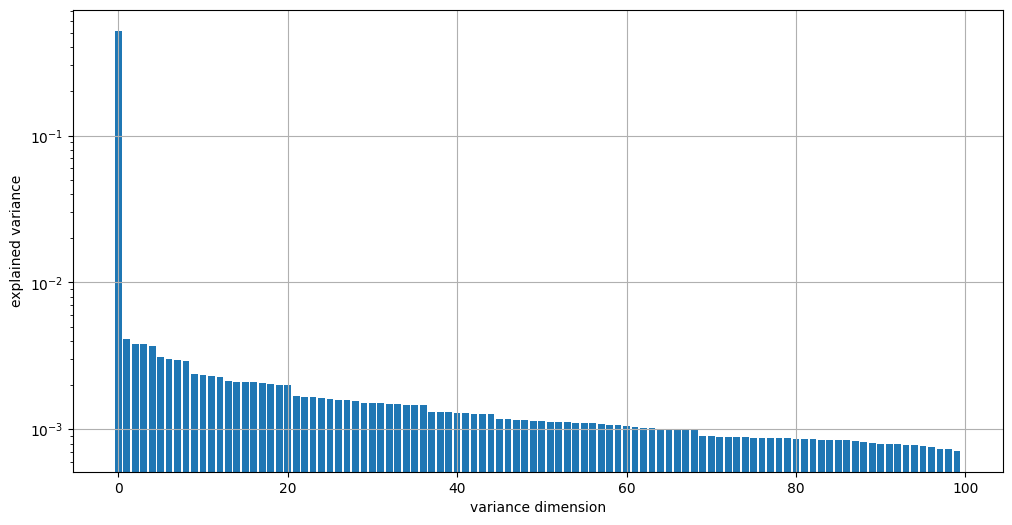

In [ ]:
print(X_train_pca.shape)

plt.figure(figsize = (12, 6))
x_range = np.linspace(0, 1599, 1600)[:100]

plt.grid('on')
plt.bar(x_range, my_pca.explained_variance_ratio_[:100])

#plt.title('explained variance per PCA dimension (log scale)')
plt.yscale('log')
plt.ylabel('explained variance')
plt.xlabel('variance dimension')

plt.savefig('PCA_variance_log')

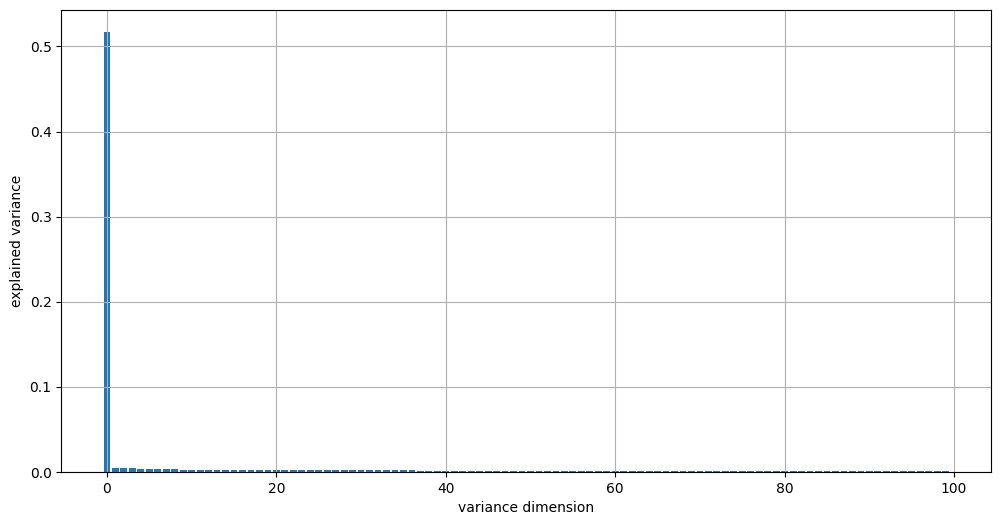

In [ ]:
plt.figure(figsize = (12, 6))
plt.grid('on')
plt.bar(x_range, my_pca.explained_variance_ratio_[:100])
#plt.title('explained variance per PCA dimension (linear scale)')
plt.ylabel('explained variance')
plt.xlabel('variance dimension')
plt.savefig('PCA_variance_lin')

$\Rightarrow$ Most variance is contained in the first dimension and decreases afterwards

In [ ]:
print(X_train_pca.shape)

(128000, 100)


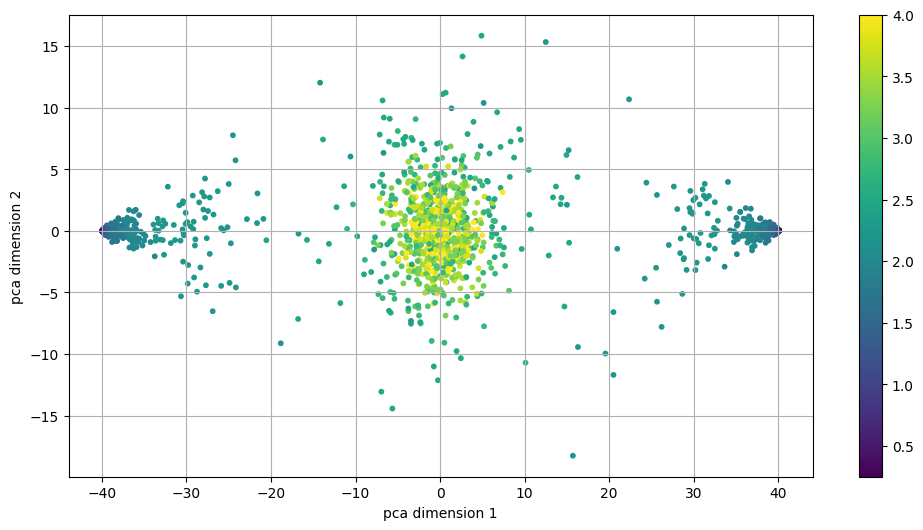

In [ ]:
plt.figure(figsize = (12, 6))
plt.scatter(X_train_pca[:2000, 0], X_train_pca[:2000, 1], c = y_train[:2000], s = 10)
plt.colorbar()
plt.grid('on')
#plt.title(r'Representation pca dim. 1 & 2 with respective temperature $t$')
plt.ylabel('pca dimension 2')
plt.xlabel('pca dimension 1')

plt.savefig('scattering_pca')

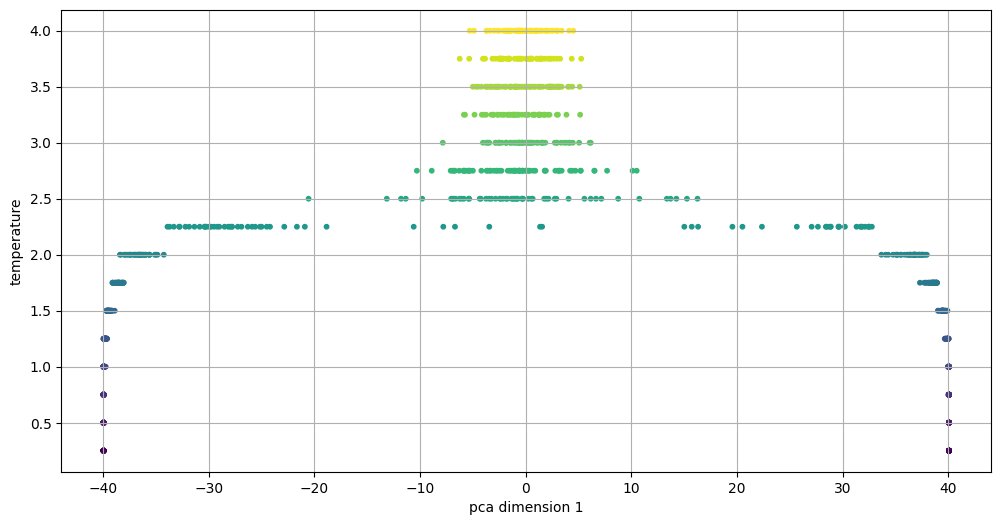

In [ ]:
plt.figure(figsize = (12, 6))
plt.scatter(X_train_pca[:1000, 0], y = y_train[:1000], c = y_train[:1000], s = 10)
plt.grid('on')
#plt.title('most important PCA dimension & temperature (on train set)')
plt.xlabel('pca dimension 1')
plt.ylabel('temperature')
plt.savefig('pca_dim_one_temperature')


### Test several baseline models - logistic regression and SVM  *on PCA dims*

**Logistic Regression**

In [ ]:
# logistic regression on the first 10 pca dimensions as a baseline model
%%time
my_log_reg = LogisticRegression(random_state=0).fit(X_train_pca[:, :10], y_train_label)

CPU times: user 3.28 s, sys: 2.52 s, total: 5.8 s
Wall time: 3.24 s


In [ ]:
my_log_reg.score(X_train_pca[:, :10], y_train_label)

0.1227734375

In [ ]:
val_score_log_reg = my_log_reg.score(X_val_pca[:, :10], y_val_label)

print('validation score logistic regression on PCA dims:', val_score_log_reg)

validation score logistic regression on PCA dims: 0.1228125


In [ ]:
# logistic regression on all dimensions
%%time
my_log_reg = LogisticRegression(random_state=0).fit(X_train, y_train_label)

CPU times: user 4min 18s, sys: 36 s, total: 4min 54s
Wall time: 3min 41s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
my_log_reg.score(X_train, y_train_label)

0.165234375

In [ ]:
val_score_log_reg = my_log_reg.score(X_val, y_val_label)

print('validation score logistic regression:', val_score_log_reg)

validation score logistic regression: 0.1100625


**Support Vector Machine**

In [ ]:
# SVM on first 10 pca dimensions
%%time
my_svm = LinearSVC(multi_class = 'ovr', max_iter = 200).fit(X_train_pca[:, :10], y_train_label)

CPU times: user 2min 14s, sys: 148 ms, total: 2min 14s
Wall time: 2min 19s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
my_svm.score(X_train_pca[:, :10], y_train_label)

0.09684375

In [ ]:
my_svm.score(X_val_pca[:, :10], y_val_label)

0.099375

**création d’un processus de pré-traitement des données** (→ utiliser
l’outil pipeline de scikit-learn)
⋄ encodage des variables catégorielles
⋄ standardisation des variables numériques
⋄ traitement d’éventuelles données manquantes

In [ ]:
# mean and std of images

#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])


In [ ]:
# Create new dataset for phase transition

## Partie 3: Détermination de scores de référence (sur les données de test)



**Regularized logistic regression**



In [ ]:
# logistic regression model with regularization parameter from 1e-5 to 1e5

In [ ]:
lmbdas = np.logspace(-5,5,11)
train_accuracy = np.zeros(lmbdas.shape,np.float64)
validation_accuracy = np.zeros(lmbdas.shape,np.float64)
train_accuracy_SGD = np.zeros(lmbdas.shape,np.float64)
validation_accuracy_SGD =np.zeros(lmbdas.shape,np.float64)

In [ ]:
for i, lmbda in enumerate(lmbdas):
    # define logistic regressor
    logreg = LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1000,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, y_train_label)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,y_train_label)
    validation_accuracy[i]=logreg.score(X_val, y_val_label)

In [ ]:
for i in range(11):
  print('accuracy: train, validation')
  print('liblin: %0.4f, %0.4f' %(train_accuracy[i],validation_accuracy[i]) )

In [ ]:
val_C = np.logspace(-5,5,11)
plt.figure(figsize=(6,6))
plt.grid('on')
plt.plot(val_C, train_accuracy,label = 'train accuracy')
plt.plot(val_C, validation_accuracy,label = 'validation accuracy')
plt.legend()
plt.xscale('log')
plt.xlabel('inverse of regularization parameter')
plt.ylabel('classification accuracy')

 **The logistic regression model with stronger regularization has better performance, so this means that there is noise in the original dataset. By selecting the most relevant feautures and train different models with these features may lead to better performance**

## Partie 4: Conception d’un modèle plus performant

In [ ]:
# CNN
# preprocessing of images --> normalization (mean, std)?

# --> can we do data aufmentations, such as rotations and flips? They should be equivalent, valid states

**Multi-layer perceptron**

In [ ]:
# firstly, we test the ordinary neuron network(multi-layer perceptron), without convolutional structure
from tensorflow import keras
nb_rows = 40
nb_cols = 40       ## the image is of 40*40 pixels

print('X_train shape:', X_train.shape, X_train.dtype)

X_train shape: (128000, 1600) float64


In [ ]:
im_size = nb_rows*nb_cols
model = keras.models.Sequential()

nb_classes = 16 ## the samples to be classified are obtainned at 16 temperatures

model.add(keras.layers.Dense(100, input_shape=(im_size,), activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(nb_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               160100    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 16)                1616      
                                                                 
Total params: 171816 (671.16 KB)
Trainable params: 171816 (671.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'])

In [ ]:
print(X_train.shape, y_train_label.shape)

(128000, 1600) (128000,)


In [ ]:
batch_size = 64
epochs = 30

history = model.fit(X_train, y_train_label, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/30
1600/1600 [==============================] - 11s 4ms/step - loss: 2.4541 - accuracy: 0.1305 - val_loss: 2.2694 - val_accuracy: 0.1498
Epoch 2/30
1600/1600 [==============================] - 7s 4ms/step - loss: 2.1589 - accuracy: 0.1852 - val_loss: 2.0678 - val_accuracy: 0.2193
Epoch 3/30
1600/1600 [==============================] - 5s 3ms/step - loss: 2.0016 - accuracy: 0.2479 - val_loss: 1.9196 - val_accuracy: 0.2791
Epoch 4/30
1600/1600 [==============================] - 8s 5ms/step - loss: 1.8882 - accuracy: 0.2908 - val_loss: 1.8369 - val_accuracy: 0.3136
Epoch 5/30
1600/1600 [==============================] - 6s 4ms/step - loss: 1.7906 - accuracy: 0.3186 - val_loss: 1.7809 - val_accuracy: 0.3248
Epoch 6/30
1600/1600 [==============================] - 6s 4ms/step - loss: 1.7182 - accuracy: 0.3357 - val_loss: 1.7079 - val_accuracy: 0.3221
Epoch 7/30
1600/1600 [==============================] - 7s 4ms/step - loss: 1.6637 - accuracy: 0.3554 - val_loss: 1.6657 - val_accuracy

In [ ]:
epoch = np.arange(1,epochs+1)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss =history.history['loss']
val_loss = history.history['val_loss']

Text(0, 0.5, 'loss ')

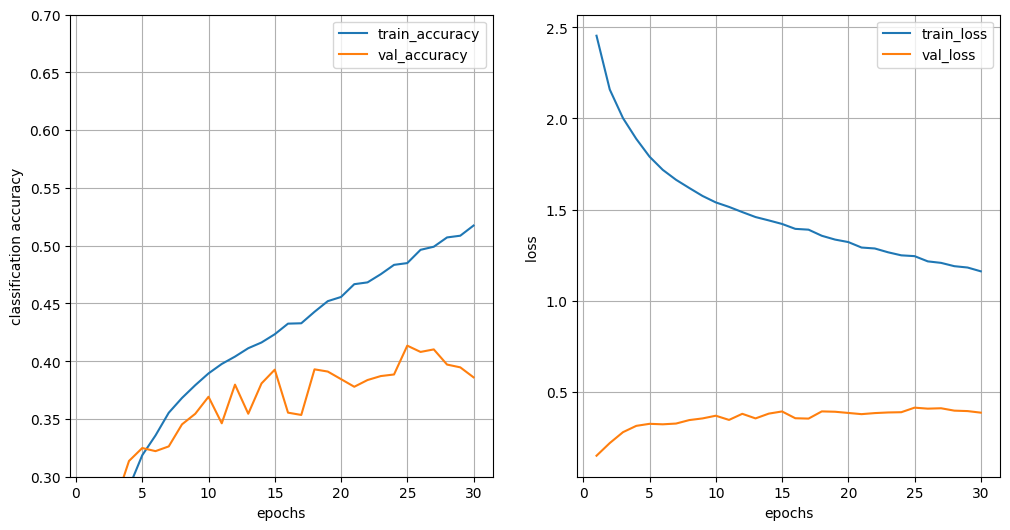

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epoch,train_accuracy,label = 'train_accuracy')
plt.plot(epoch,val_accuracy, label= 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('classification accuracy')
plt.ylim(0.3,0.7)
plt.grid('on')
plt.legend()
plt.subplot(1,2,2)

plt.plot(epoch,train_loss,label = 'train_loss')
plt.plot(epoch,val_accuracy, label= 'val_loss')
plt.legend()
plt.grid('on')
plt.xlabel('epochs')
plt.ylabel('loss ')


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred_label = model.predict(X_test)



500/500 [==============================] - 1s 2ms/step


In [ ]:
new_y_pred = np.zeros(np.shape(y_pred_label)[0])
for i in range(np.shape(y_pred_label)[0]):
  a = y_pred_label[i]
  new_y_pred[i] = np.argmax(a)

In [ ]:
conf_16_16_matrix=confusion_matrix(y_test_label,new_y_pred)
conf_16_16_matrix

array([[487,   0,   0,   0,   0,   0, 519,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [488,   0,   0,   0,   0,   0, 490,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [467,   0,   0,   5,  13,   0, 481,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [302,   0,   0,  63, 161,   0, 511,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 28,   0,   0,  32, 468,  50, 407,   4,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0, 135, 401, 411,  39,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,  35,  50, 639, 265,   1,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   9,   0,  65, 865,  58,   2,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 120, 808,  57,   3,   3,   0,
          0,   0,   5],
       [  0,   0,   0,   0,   0,   0,   0,   0,  47, 617, 244,  94,  11,
          1,   0,   1],
       [  0,   0,   0,   0,   

<Axes: >

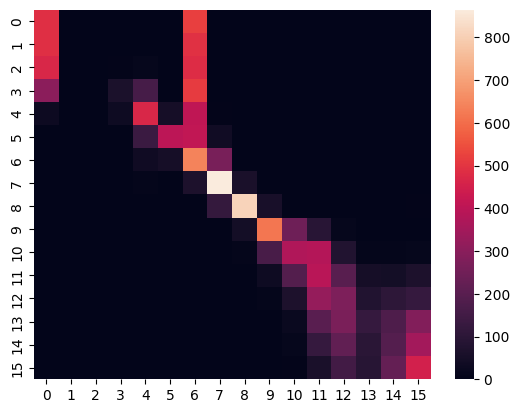

In [ ]:
sns.heatmap(conf_16_16_matrix) # confusion matrix for 16 classification categories, is it resonable to consider less classes?

**Generally, the multi-layer perceptron model can classify the samples at 16 different temperatures with an accuracy around 40%**

**Covolutional neronal network**

**Now, we will add the convolutionary structure to the neuroal network to see if this will improve the model performance**

In [ ]:
from tensorflow import keras

In [ ]:
nb_rows = 40
nb_cols = 40
nb_classes = 16
X_train_2D = X_train.reshape(X_train.shape[0], nb_rows, nb_cols, 1)
X_test_2D = X_test.reshape(X_test.shape[0], nb_rows, nb_cols, 1)

print('X_train shape:', X_train_2D.shape, X_train.dtype)
print('y_train shape (one-hot encoding):', y_train_label.shape, y_train_label.dtype)

X_train shape: (128000, 40, 40, 1) float64
y_train shape (one-hot encoding): (128000,) int64


In [ ]:
model_CNN = keras.models.Sequential()

model_CNN.add(keras.layers.Conv2D(20, kernel_size=(5, 5),
                                  activation='relu',
                                  input_shape=(nb_rows,nb_cols,1)))
model_CNN.add(keras.layers.Flatten())

model_CNN.add(keras.layers.Dense(nb_classes, activation='softmax'))

In [ ]:
model_CNN.compile(loss='sparse_categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

In [ ]:
batch_size = 64
epochs = 30

history = model_CNN.fit(X_train_2D, y_train_label, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/30
1600/1600 [==============================] - 10s 5ms/step - loss: 1.4578 - accuracy: 0.3967 - val_loss: 1.2468 - val_accuracy: 0.4816
Epoch 2/30
1600/1600 [==============================] - 6s 4ms/step - loss: 1.0727 - accuracy: 0.5506 - val_loss: 1.1982 - val_accuracy: 0.5041
Epoch 3/30
1600/1600 [==============================] - 8s 5ms/step - loss: 0.9298 - accuracy: 0.6095 - val_loss: 1.1711 - val_accuracy: 0.5091
Epoch 4/30
1600/1600 [==============================] - 6s 4ms/step - loss: 0.8424 - accuracy: 0.6487 - val_loss: 1.2510 - val_accuracy: 0.4762
Epoch 5/30
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7438 - accuracy: 0.6864 - val_loss: 1.2862 - val_accuracy: 0.4870
Epoch 6/30
1600/1600 [==============================] - 6s 4ms/step - loss: 0.7133 - accuracy: 0.7017 - val_loss: 1.3084 - val_accuracy: 0.4839
Epoch 7/30
1600/1600 [==============================] - 6s 4ms/step - loss: 0.6757 - accuracy: 0.7171 - val_loss: 1.3916 - val_accuracy

In [ ]:
epoch = np.arange(1,epochs+1)
CNN_train_accuracy = history.history['accuracy']
CNN_val_accuracy = history.history['val_accuracy']
CNN_train_loss =history.history['loss']
CNN_val_loss = history.history['val_loss']

Text(0, 0.5, 'loss ')

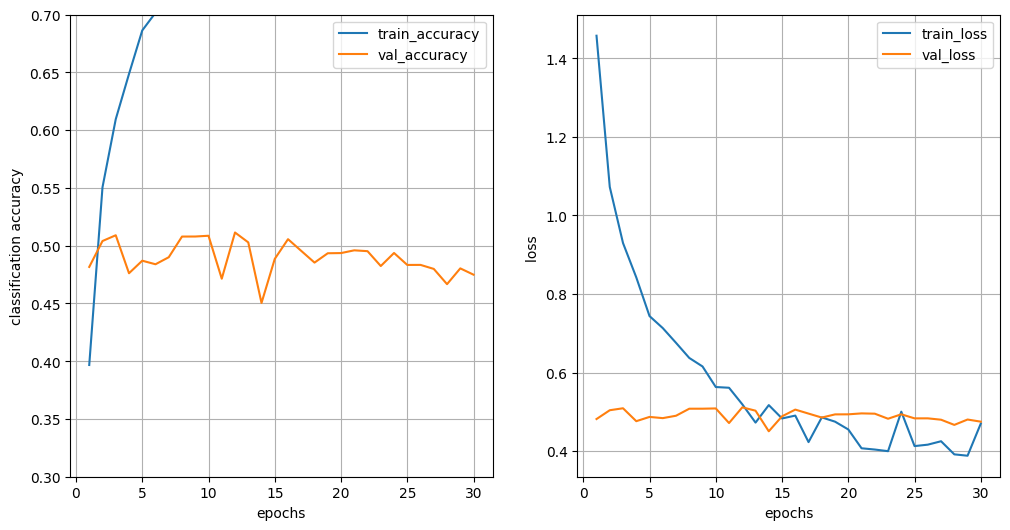

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epoch,CNN_train_accuracy,label = 'train_accuracy')
plt.plot(epoch,CNN_val_accuracy, label= 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('classification accuracy')
plt.ylim(0.3,0.7)
plt.grid('on')
plt.legend()
plt.subplot(1,2,2)

plt.plot(epoch,CNN_train_loss,label = 'train_loss')
plt.plot(epoch,CNN_val_accuracy, label= 'val_loss')
plt.legend()
plt.grid('on')
plt.xlabel('epochs')
plt.ylabel('loss ')

**Compared with multi-layer perceptron model, the CNN  model has a higher classification accuray: around 50% on the validation set.**

**Reduce the number of classes**

By observing the confusion matrix of 16 temperature classification, and  considering the fact that the highest accuracy achieved by models is 50%.We decide to reduce the number of classes by combining several temperatures into one single phase, and the rest to form another phase. The critical temperature of the two phase is between 2.00 and 2.50.

In [ ]:
#combine images obtained at 0.25-1.75 to form phase 1. (Label 1)

In [ ]:
#combine images obtained at 2.75-4.00 to form phase 2 (Label 2)

In [ ]:
# train models with new labels to classify the images at 2.00 , 2.25 and 2.50